 # NASA Dataset Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

from nasa.dataset import NASADataset
from util import get_config

## Load Dataset

In [2]:
config_file_path = f"configs/nasa_config.json"
config = get_config(config_file_path)

In [3]:
nasa = NASADataset(config)
i=0

Extracting data/NASA_raw/NASA.zip
Converting NASA dataset
/B0005.mat --> B0005
/B0006.mat --> B0006
/B0007.mat --> B0007
/B0018.mat --> B0018
/B0025.mat --> B0025
/B0026.mat --> B0026
/B0027.mat --> B0027
/B0028.mat --> B0028
/B0029.mat --> B0029
/B0030.mat --> B0030
/B0031.mat --> B0031
/B0032.mat --> B0032
/B0033.mat --> B0033
/B0034.mat --> B0034
/B0036.mat --> B0036
/B0038.mat --> B0038
/B0039.mat --> B0039
/B0040.mat --> B0040
/B0041.mat --> B0041
/B0042.mat --> B0042
/B0043.mat --> B0043
/B0044.mat --> B0044
/B0045.mat --> B0045
/B0046.mat --> B0046
/B0047.mat --> B0047
/B0048.mat --> B0048
/B0049.mat --> B0049
/B0050.mat --> B0050
/B0051.mat --> B0051
/B0052.mat --> B0052
/B0053.mat --> B0053
/B0054.mat --> B0054
/B0055.mat --> B0055
/B0056.mat --> B0056


## Helper Methods for Visualization

In [4]:
def format_impedance_df(impedance_df, columns):
    tmp_data = impedance_df
    for col in columns:
        new_col = tmp_data[col]
        new_col = new_col.str.strip()
        new_col = pd.Series([abs(complex(val)) for val in new_col])
        tmp_data[col] = new_col
    return tmp_data

In [5]:
def get_columns(data):
    if "Voltage_charge" in data.columns:
        operation = "charge"
        columns = ["Time", "Voltage_measured", "Current_measured", "Voltage_charge", "Current_charge", "Temperature_measured"]
    elif "Voltage_load" in data.columns:
        operation = "discharge"
        columns = ["Time", "Voltage_measured", "Current_measured", "Voltage_load", "Current_load", "Temperature_measured"]
        temp = data["Temperature_measured"]
        # print("Max Temp: ", max(temp))
        # print("Min Temp: ", min(temp))
        # print("Temp Amp: ", max(temp)-min(temp))
    elif "Battery_impedance" in data.columns:
        operation = "impedance"
        columns = ["Sense_current", "Battery_current","Battery_impedance", "Rectified_Impedance"]#, "Current_ratio"]
        data = format_impedance_df(data, columns)
    return operation, columns, data


def plot_data(data):
    if "Battery_impedance" in data.columns:
        operation, columns, data = get_columns(data)
    else:
        operation, columns, _ = get_columns(data)

    fig, axs = plt.subplots(2, 2)
    if operation == "impedance":
        axs[0, 0].plot(data[columns[0]])
        axs[0, 0].set_title(columns[0])
        axs[0, 1].plot(data[columns[1]])
        axs[0, 1].set_title(columns[1])
        axs[1, 0].plot(data[columns[2]])
        axs[1, 0].set_title(columns[2])
        axs[1, 1].plot(data[columns[3]])
        axs[1, 1].set_title(columns[3])
        fig.savefig("Example_Impedance_Measurement.png")
    else:
        axs[0, 0].plot(data[columns[0]], data[columns[1]])
        axs[0, 0].set_title(columns[1])
        axs[0, 1].plot(data[columns[0]], data[columns[2]])
        axs[0, 1].set_title(columns[2])
        axs[1, 0].plot(data[columns[0]], data[columns[3]])
        axs[1, 0].set_title(columns[3])
        axs[1, 1].plot(data[columns[0]], data[columns[4]])
        axs[1, 1].set_title(columns[4])


In [6]:
def plot_data_compared(charge_data_first_cycle, discharge_data_first_cycle, charge_data_last_cycle, discharge_data_last_cycle, cell_name):
    if "Battery_impedance" in charge_data_first_cycle.columns:
        operation, charge_columns, charge_data_first_cycle = get_columns(charge_data_first_cycle)
    else:
        operation, charge_columns, _ = get_columns(charge_data_first_cycle)
    
    if "Battery_impedance" in discharge_data_first_cycle.columns:
        operation, discharge_columns, discharge_data_first_cycle = get_columns(discharge_data_first_cycle)
    else:
        operation, discharge_columns, _ = get_columns(discharge_data_first_cycle)

    if "Battery_impedance" in charge_data_last_cycle.columns:
        operation, columns1, charge_data_last_cycle = get_columns(charge_data_last_cycle)
    else:
        operation, columns1, _ = get_columns(charge_data_last_cycle)
    
    if "Battery_impedance" in discharge_data_last_cycle.columns:
        operation, columns2, discharge_data_last_cycle = get_columns(discharge_data_last_cycle)
    else:
        operation, columns2, _ = get_columns(discharge_data_last_cycle)

    subtitles = ["Laden", "Entladen"]
    first_cycles_data = [charge_data_first_cycle, discharge_data_first_cycle]
    last_cycles_data = [charge_data_last_cycle, discharge_data_last_cycle]
    columns = [charge_columns, discharge_columns]
    fig = plt.figure(constrained_layout=True, figsize=(24, 9))
    # subfigs = fig.subfigures(2, 1)
    subfigs = fig.subfigures(1, 3)
    fig.suptitle(f"{cell_name}: Vergleich Start- und Endzyklus")
    first_cycle_text = "erster_Zyklus"
    last_cycle_text = "letzter_Zyklus"
    time_description = "Time (s)"
    voltage_description = "Voltage (V)"
    current_description = "Current (A)"
    for outerind, subfig in enumerate(subfigs.flat):
        if outerind == 2: # plot temperature in seprarate subplots on the right
            ax1, ax2 = subfig.subplots(2)
            ax1.plot(first_cycles_data[0][charge_columns[0]], first_cycles_data[0][charge_columns[5]], label=f"Temperatur_{first_cycle_text}")
            ax1.plot(last_cycles_data[0][charge_columns[0]], last_cycles_data[0][charge_columns[5]], label=f"Temperatur_{last_cycle_text}")
            ax1.set_xlabel(time_description)
            ax1.set_ylabel("Temperature (°C)")
            ax1.set_title(f"{subtitles[0]}: {charge_columns[5]}")
            ax1.legend()
            ax2.plot(first_cycles_data[1][discharge_columns[0]], first_cycles_data[1][discharge_columns[5]], label=f"Temperatur_{first_cycle_text}")
            ax2.plot(last_cycles_data[1][discharge_columns[0]], last_cycles_data[1][discharge_columns[5]], label=f"Temperatur_{last_cycle_text}")
            ax2.set_xlabel(time_description)
            ax2.set_ylabel("Temperature (°C)")
            ax2.set_title(f"{subtitles[1]}: {discharge_columns[5]}")
            ax2.legend()
        else: # plot cycles for charging and discharging in separate subplots
            process = subtitles[outerind]
            subfig.suptitle(process)
            axs = subfig.subplots(2, 2)
            axs[0, 0].plot(first_cycles_data[outerind][columns[outerind][0]], first_cycles_data[outerind][columns[outerind][1]], label=f"V_Mess_{first_cycle_text}")
            axs[0, 0].plot(last_cycles_data[outerind][columns[outerind][0]], last_cycles_data[outerind][columns[outerind][1]], label=f"V_Mess_{last_cycle_text}")
            axs[0, 0].set_xlabel(time_description)
            axs[0, 0].set_ylabel(voltage_description)
            axs[0, 0].set_title(columns[outerind][1])
            axs[0, 0].legend()
            axs[0, 1].plot(first_cycles_data[outerind][columns[outerind][0]], first_cycles_data[outerind][columns[outerind][2]], label=f"C_Mess_{first_cycle_text}")
            axs[0, 1].plot(last_cycles_data[outerind][columns[outerind][0]], last_cycles_data[outerind][columns[outerind][2]], label=f"C_Mess_{last_cycle_text}")
            axs[0, 1].set_xlabel(time_description)
            axs[0, 1].set_ylabel(current_description)
            axs[0, 1].set_title(columns[outerind][2])
            axs[0, 1].legend()
            axs[1, 0].plot(first_cycles_data[outerind][columns[outerind][0]], first_cycles_data[outerind][columns[outerind][3]], label=f"V_{process}_{first_cycle_text}")
            axs[1, 0].plot(last_cycles_data[outerind][columns[outerind][0]], last_cycles_data[outerind][columns[outerind][3]], label=f"V_{process}_{last_cycle_text}")
            axs[1, 0].set_xlabel(time_description)
            axs[1, 0].set_ylabel(voltage_description)
            axs[1, 0].set_title(columns[outerind][3])
            axs[1, 0].legend()
            axs[1, 1].plot(first_cycles_data[outerind][columns[outerind][0]], first_cycles_data[outerind][columns[outerind][4]], label=f"C_{process}_{first_cycle_text}")
            axs[1, 1].plot(last_cycles_data[outerind][columns[outerind][0]], last_cycles_data[outerind][columns[outerind][4]], label=f"C_{process}_{last_cycle_text}")
            axs[1, 1].set_xlabel(time_description)
            axs[1, 1].set_ylabel(current_description)
            axs[1, 1].set_title(columns[outerind][4])
            axs[1, 1].legend()
    plt.savefig(f"nasa_{cell_name}_comparison_first_last_cycle.png")

def plot_cycle(data_dir, index):
    str_index = f'{index:05d}'
    data_1 = pd.read_csv(data_dir + f"{str_index}.csv")
    # time = data_1["Time"]
    str_index = f'{index+1:05d}'
    data_2 = pd.read_csv(data_dir + f"{str_index}.csv", sep=",")
    plot_data(data_1)
    plot_data(data_2)

def plot_cycles_compared(data_dir, index1, index2, cell_name):
    # process data 1
    str_index = f'{index1:05d}'
    first_cycles_charge_data = pd.read_csv(data_dir + f"{str_index}.csv")
    str_index = f'{index1+1:05d}'
    first_cycles_discharge_data = pd.read_csv(data_dir + f"{str_index}.csv", sep=",")
    # process data 2
    str_index = f'{index2:05d}'
    last_cycles_charge_data = pd.read_csv(data_dir + f"{str_index}.csv")
    str_index = f'{index2+1:05d}'
    # str_index = f'{index2+2:05d}'
    last_cycles_discharge_data = pd.read_csv(data_dir + f"{str_index}.csv", sep=",")

    plot_data_compared(first_cycles_charge_data, first_cycles_discharge_data, last_cycles_charge_data, last_cycles_discharge_data, cell_name)


## Comparison of first and last cycle for each cell

170
168


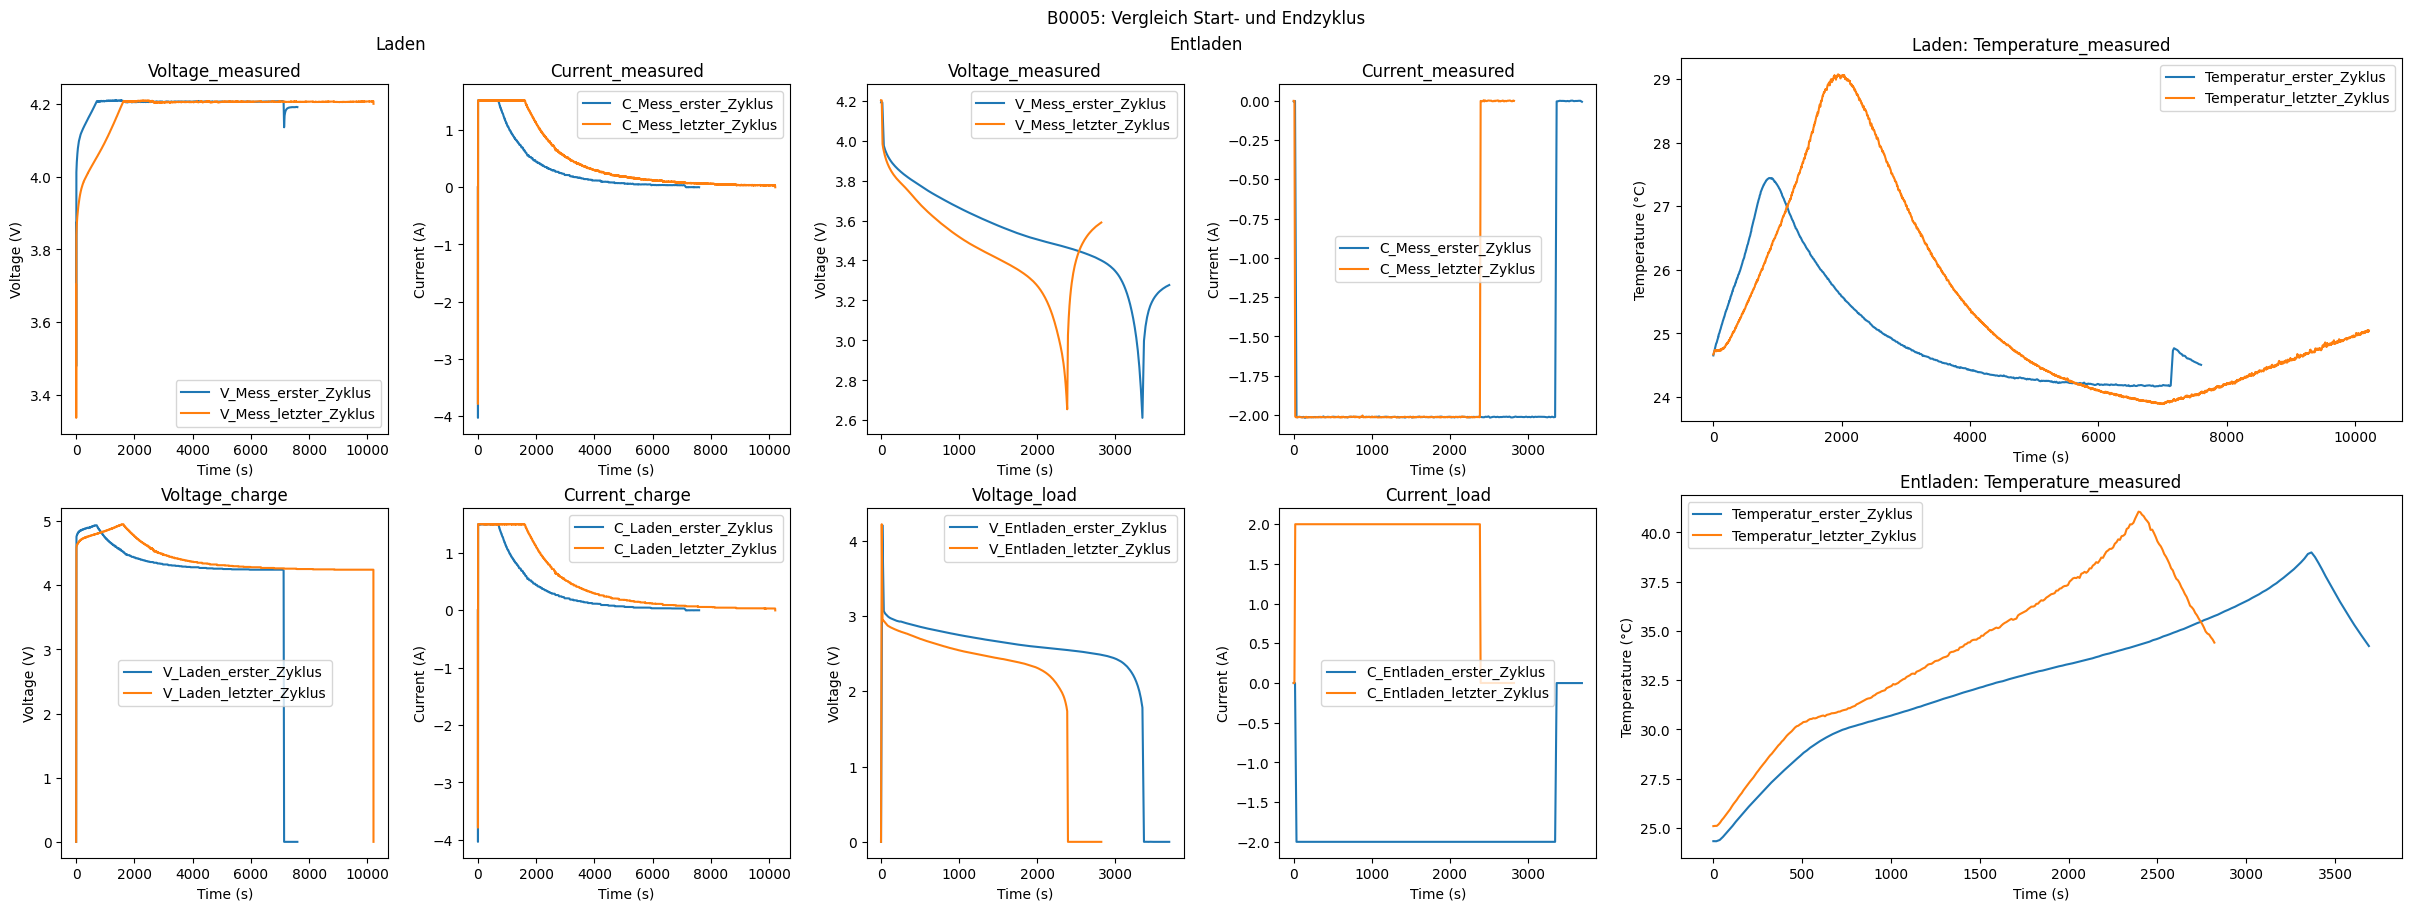

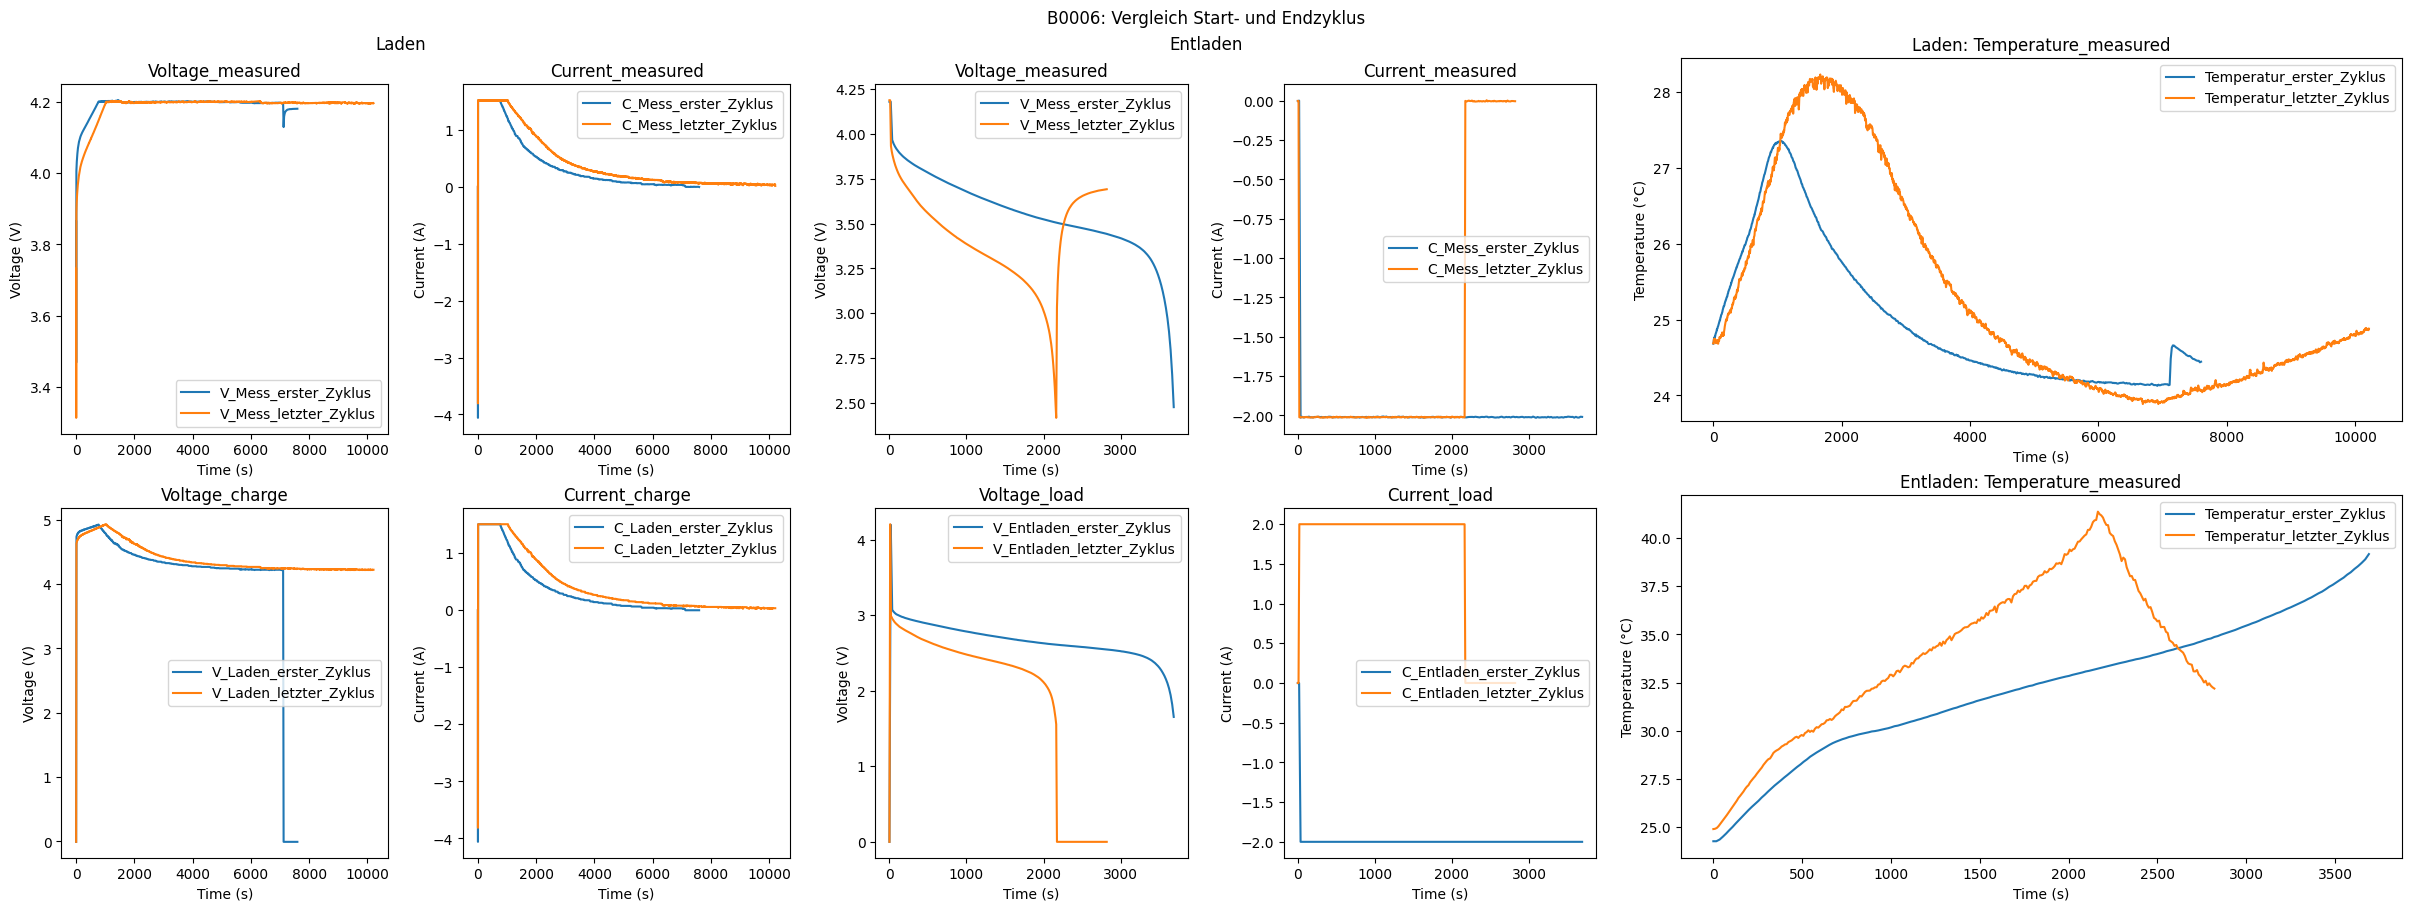

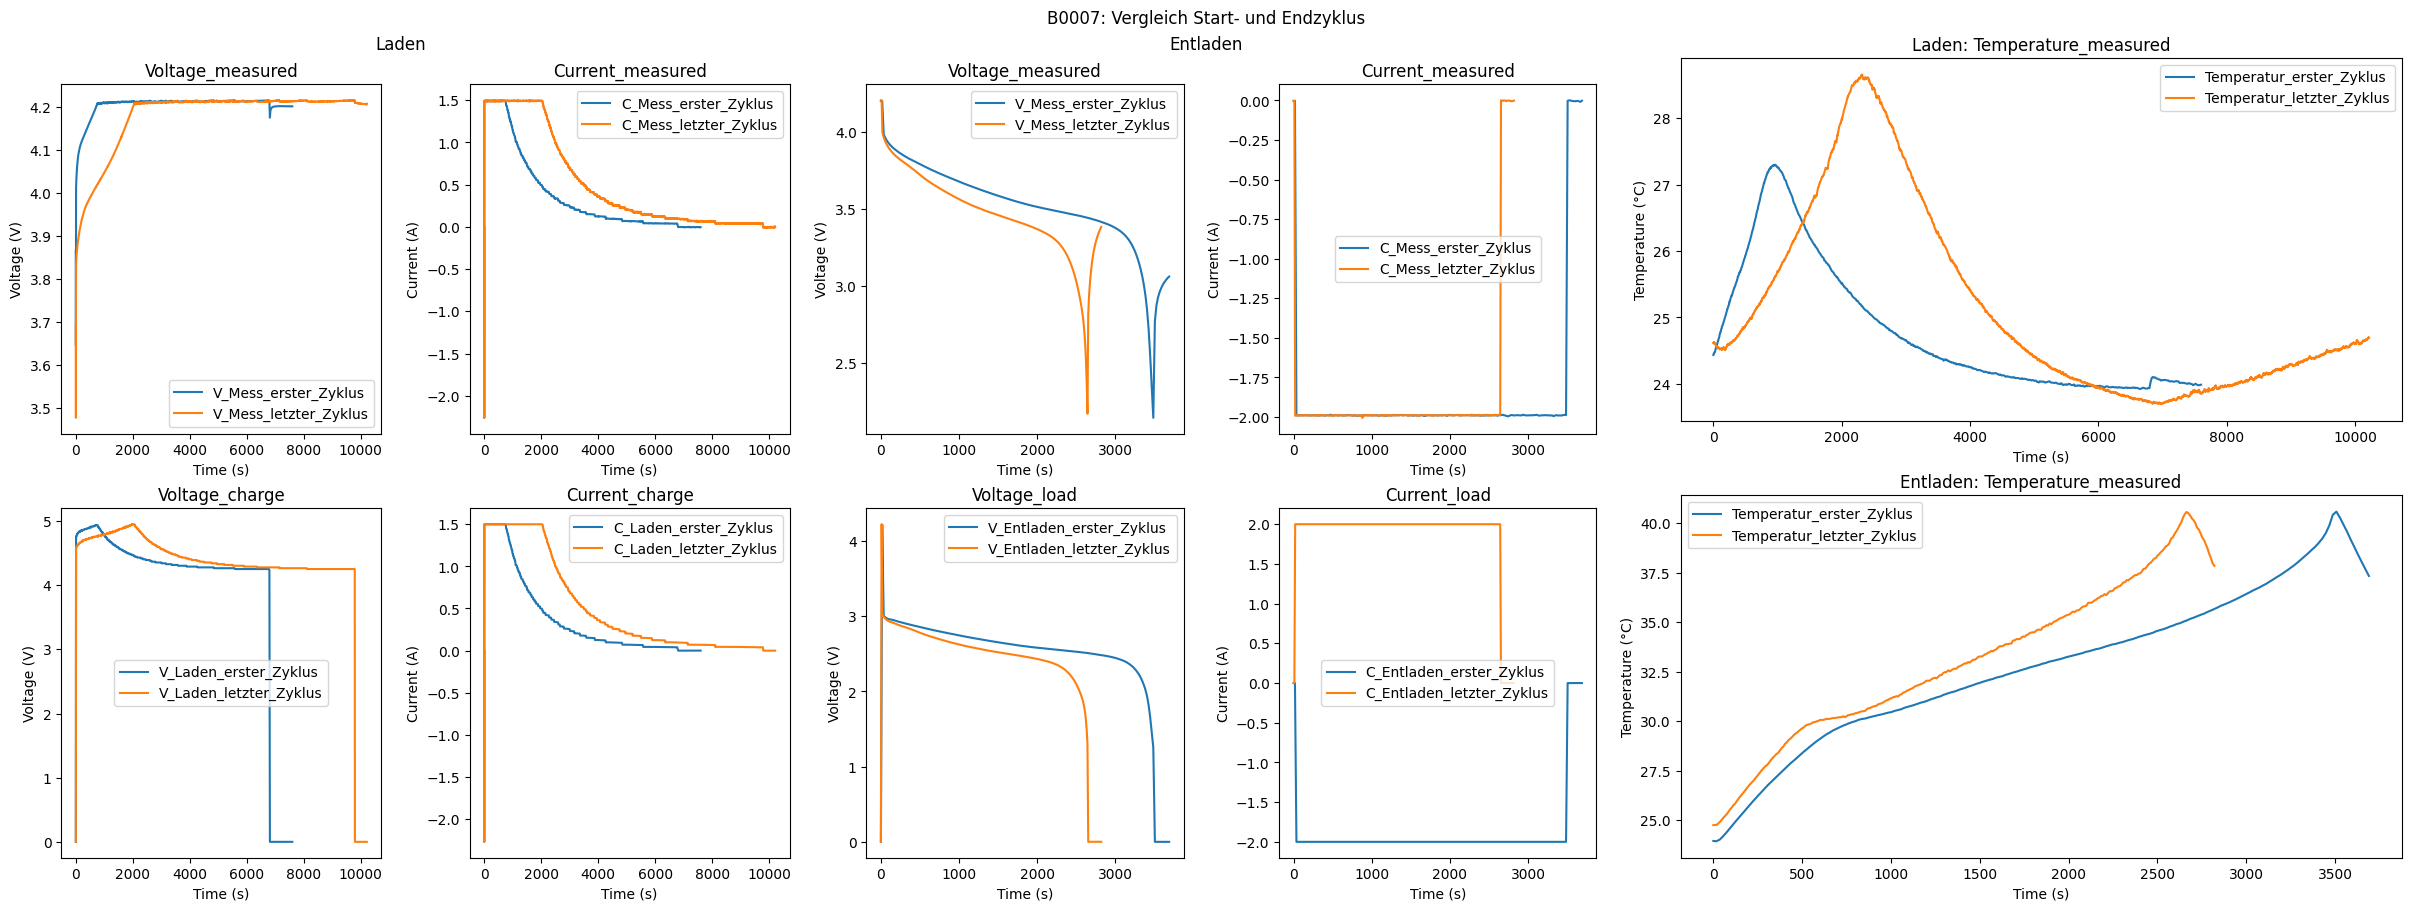

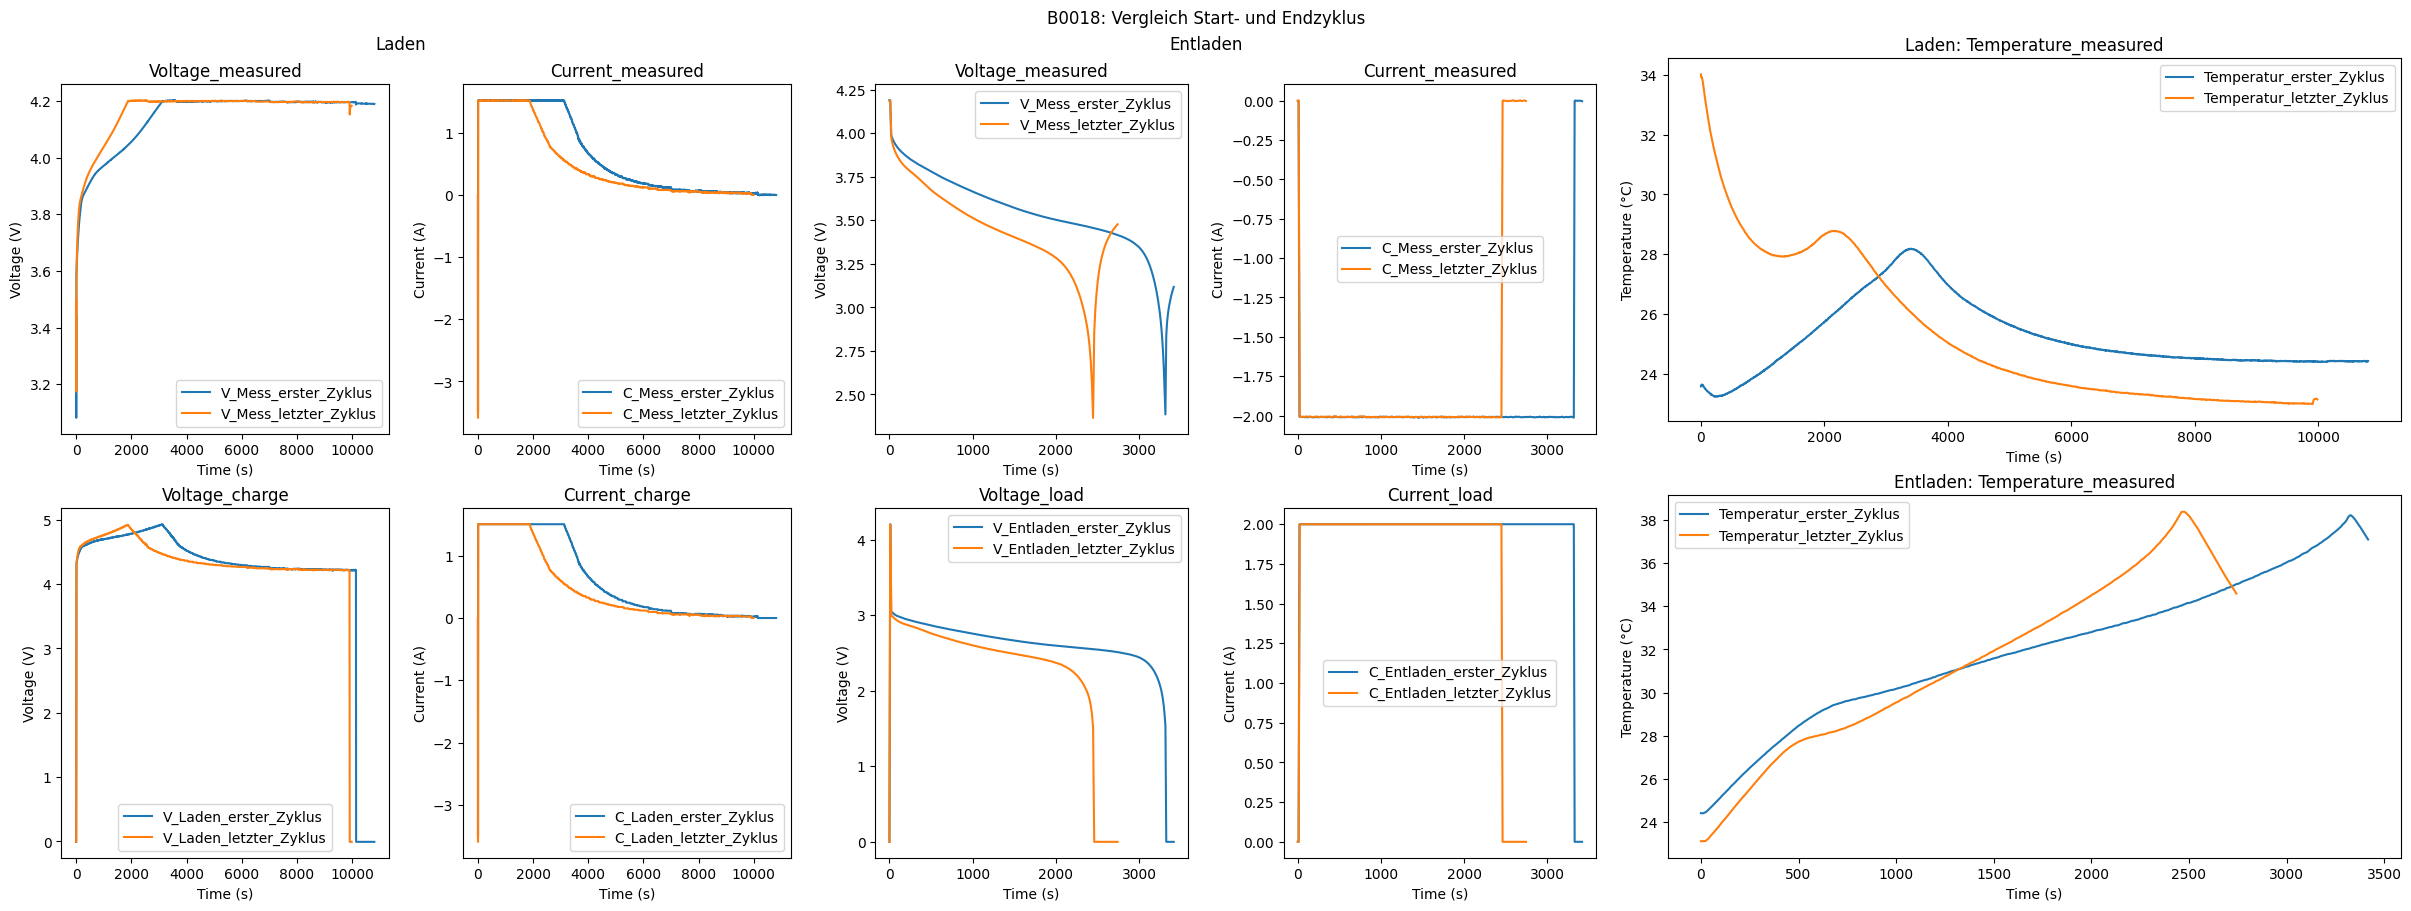

In [7]:
data_dir = "data/NASA/data/"
metadata = pd.read_csv("data/NASA/metadata.csv")
eols = {'B0005': 124, 'B0006': 108, 'B0007': -1, 'B0018': 96}
indices_first_cycle = [1, 617, 1233, 1865]
indices_last_cycle = [613, 1229, 1845, 2166]
cells = ["B0005", "B0006", "B0007", "B0018"]

# indices_eol_cycle = []

# cells = ["B0005", "B0006"]#, "B0018"]
# indices_first_cycle = [1, 617]#, 1865]

data = pd.read_csv("data/NASA/metadata.csv")
cell_data = data[data["battery_id"] == "B0005"]
charge_data = cell_data[cell_data["type"] == "charge"]
discharge_data = cell_data[cell_data["type"] == "discharge"]
print(len(charge_data))
print(len(discharge_data))

for cell in cells:
    cell_data = data[data["battery_id"] == cell]
    discharge_data = cell_data[cell_data["type"] == "discharge"]
    eol_filename = discharge_data.iloc[eols[cell]]["filename"]
    # eol_cycle_uid = eol_cycle["uid"]
    # eol1 = eol_cycle_uid-1
    # eol2 = eol_cycle_uid-2
    # prev_data = data[data["uid"] == eol1]["type"]
    # prev_data_2 = data[data["uid"] == eol2]["type"]
    # if prev_data == "charge":
    #     print("A")
    # elif prev_data_2 == "charge":
    #     print("B")
    
    # eol_filename = os.path.splitext(eol_filename)[0]
    # indices_eol_cycle.append(int(eol_filename)-2)

for i in range(len(indices_first_cycle)):
    plot_cycles_compared(data_dir, indices_first_cycle[i], indices_last_cycle[i], cells[i])

In [8]:
import ast
import re
from datetime import datetime

measurement_times = {}
normal_measurement_times = {}
epoch_time = datetime(1970, 1, 1)


cells = ["B0005", "B0006", "B0007", "B0018"]
for cell in cells:
    cell_data = nasa.cell_data_dfs[cell]
    discharge_df = cell_data[cell_data["type"] == "discharge"]
    for _, df_line in discharge_df.iterrows():
        try:
            timestamp = df_line["start_time"]
            timestamp = re.sub(' +', ', ', timestamp) # get string representation of list into right format
            timestamp = ast.literal_eval(timestamp) # convert string representation of list to list
            timestamp = [int(stamp) for stamp in timestamp] # convert float list values to integer
            timestamp = datetime(*timestamp) # create datetime object from list of date information
            timestamp_seconds = (timestamp-epoch_time).total_seconds() # calculate total seconds from starttime
        except ValueError:
            print("Error when reading timestamp")
            pass
        if df_line["battery_id"] not in measurement_times:
            measurement_times[df_line["battery_id"]] = []
        measurement_times[df_line["battery_id"]].append(timestamp_seconds)
        normal_measurement_times[cell] = [dt-measurement_times[cell][0]for dt in measurement_times[cell]]

for cell in cells:
    print(f"-----{cell}-----")
    print(measurement_times[cell])
    print(normal_measurement_times[cell])
    print(len(measurement_times[cell]))

-----B0005-----
[1207149941.0, 1207165428.0, 1207180866.0, 1207196197.0, 1207211605.0, 1207227310.0, 1207243036.0, 1207258094.0, 1207273095.0, 1207288088.0, 1207303039.0, 1207331787.0, 1207346514.0, 1207362026.0, 1207376701.0, 1207391432.0, 1207406081.0, 1207420765.0, 1207435595.0, 1208553019.0, 1208572149.0, 1208591235.0, 1208610102.0, 1208629649.0, 1208648515.0, 1208667281.0, 1208686588.0, 1208705825.0, 1208724638.0, 1208744102.0, 1208878429.0, 1208895978.0, 1208913491.0, 1208931499.0, 1208948880.0, 1208966785.0, 1208984578.0, 1209001893.0, 1209019800.0, 1209037764.0, 1209055556.0, 1209073091.0, 1209125024.0, 1209153835.0, 1209171875.0, 1209189455.0, 1209207505.0, 1209471356.0, 1209488727.0, 1209506404.0, 1209523435.0, 1209541302.0, 1209558529.0, 1209576016.0, 1209593694.0, 1209611733.0, 1209629763.0, 1209647664.0, 1209665470.0, 1209683415.0, 1209700414.0, 1209717880.0, 1209735785.0, 1209755268.0, 1209770657.0, 1209787988.0, 1209805819.0, 1209823474.0, 1209841093.0, 1209858150.0, 120

In [9]:
cell = "B0005"
b0005_data = nasa.cell_data_dfs[cell]
b0005_discharge_data = b0005_data[b0005_data["type"] == "discharge"]
filenames = [file for file in b0005_discharge_data["filename"]]

discharge_times = []
delta_temps = []

for file in filenames:
    cycle_data = pd.read_csv(f"data/NASA/data/{file}")

    V_meas = cycle_data["Voltage_measured"]
    V_meas_max_idx = V_meas.idxmax()
    V_meas_min_idx = V_meas.idxmin()

    discharge_time = cycle_data["Time"][V_meas_min_idx]-cycle_data["Time"][V_meas_max_idx]
    discharge_times.append(discharge_time)

    temp_meas = cycle_data["Temperature_measured"]
    delta_temp = temp_meas[V_meas_min_idx] - temp_meas[V_meas_max_idx]
    delta_temps.append(delta_temp)

normal_discharge_times = [dis_time/max(discharge_times) for dis_time in discharge_times]
normal_delta_temps = [temp/max(delta_temps) for temp in delta_temps]

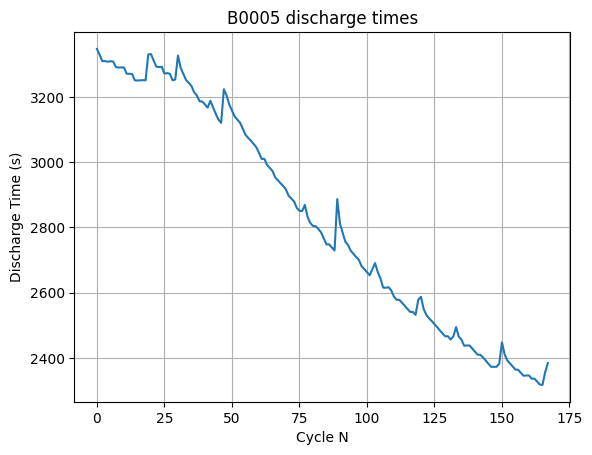

In [10]:
plt.figure()
plt.title("B0005 discharge times")
plt.plot(discharge_times)
plt.xlabel("Cycle N")
plt.ylabel("Discharge Time (s)")
plt.grid()

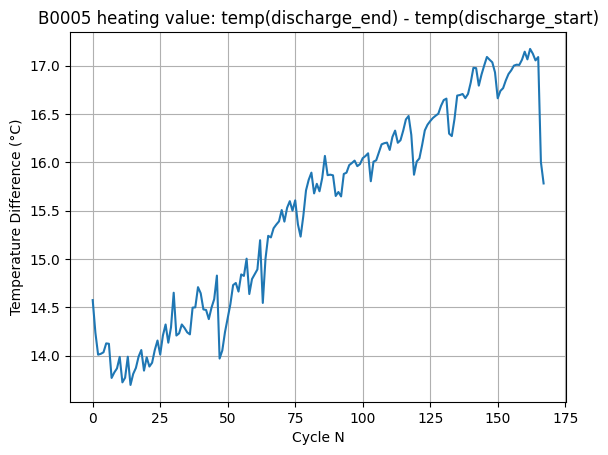

In [11]:
plt.figure()
plt.title("B0005 heating value: temp(discharge_end) - temp(discharge_start)")
plt.plot(delta_temps)
plt.xlabel("Cycle N")
plt.ylabel("Temperature Difference (°C)")
plt.grid()

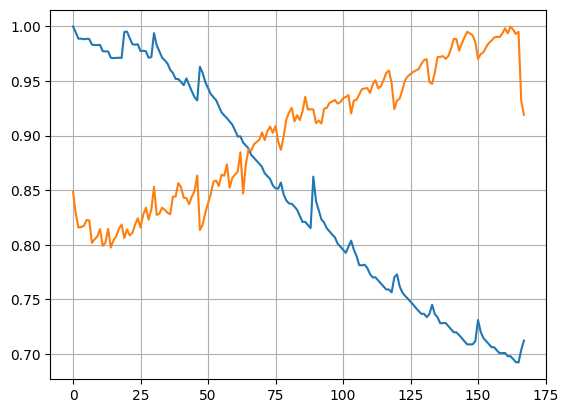

In [12]:
plt.figure()
plt.plot(normal_discharge_times)
plt.plot(normal_delta_temps)
plt.grid()
plt.grid(visible=True, which='minor')